<a href="https://colab.research.google.com/github/Alex-Chen1121/Machine-learning/blob/main/7_13_%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basic module
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # progress bar

# PyTorch
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms # 資料前處理

In [ ]:
# print version of PyTorch
torch.__version__, torchvision.__version__

('2.0.1+cu118', '0.15.2+cu118')

執行階段 -> 變更執行階段類型

In [ ]:
!nvidia-smi

Tue Sep  5 05:37:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Prepare CIFAR10 Dataset

*   torch vision datasets: https://pytorch.org/vision/stable/datasets.html
*   CIFAR10 label

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck

In [ ]:
# Define Parameters
NUM_CLASS = 10
# Class name and class mapping
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]
class_map = {cls: i for i, cls in enumerate(class_names)}
print(class_map)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


#### torch.utils.data.Dataset

https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset

*   read **1** sample (img, label)
*   Convert to **Torch.Tensor**
* Datasets provided by torchvision https://pytorch.org/vision/stable/datasets.html


In [ ]:
# Download dataset
train_ds = torchvision.datasets.CIFAR10('data', # saved path
    train=True, # training or testing set
    download=True # download dataset from internet
)
val_ds = torchvision.datasets.CIFAR10('data',
    train=False,
    download=True
)

100%|██████████| 170498071/170498071 [00:01<00:00, 103217942.34it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
# Check your dataset
print('Number of training   samples:', len(train_ds))
print('Number of validation samples:', len(val_ds))

Number of training   samples: 50000
Number of validation samples: 10000


In [ ]:
# Random select a sample
idx = np.random.randint(low=0, high=len(train_ds))
img, label = train_ds[idx]

# Type of img and label
print(idx)
print(type(img), type(label))

34914
<class 'PIL.Image.Image'> <class 'int'>


img shape:  (32, 32, 3)
label:  3
class name:  cat


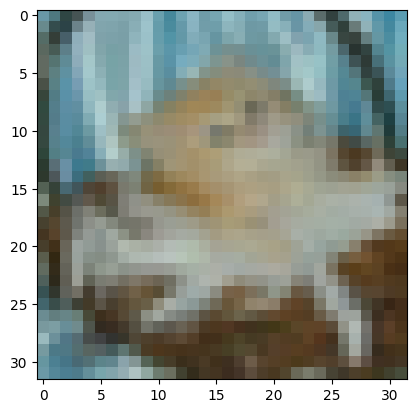

In [ ]:
# Convert to np.ndarray and show image
img_np = np.array(img)
print('img shape: ', img_np.shape)
print('label: ', label)
print('class name: ', class_names[label])
plt.imshow(img_np)
plt.show()

#### Data Proprocess



1.   Convert **PIL.Image** to **torch.FloatTensor** (張量)
  

*   Converts a **PIL Image or numpy.ndarray** (H, W, C) in the range [0, 255] to a **torch.FloatTensor** of shape (C, H, W) in the range [0.0, 1.0]

2.   TODO: Data Augmentation, ... etc



In [ ]:
preprocess = transforms.Compose([
    transforms.ToTensor(), # Convert to Tensor
    # ...
])

In [ ]:
# Build dataset with data preprocess
train_ds = torchvision.datasets.CIFAR10('data',
    train=True,
    download=True,
    transform=preprocess)
val_ds = torchvision.datasets.CIFAR10('data',
    train=False,
    download=True,
    transform=preprocess)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Random select a sample
idx = np.random.randint(low=0, high=len(train_ds))
img, label = train_ds[idx]

# Type of img and label
print(idx)
print(type(img), type(label))
print(img.shape)

522
<class 'torch.Tensor'> <class 'int'>
torch.Size([3, 32, 32])


#### Combine Dataset with DataLoader

**torch.utils.data.DataLoader**: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

* form a **batch**
* data sampler
* reading order (shuffle)

In [ ]:
# Use DataLoader to generate minibatches
BATCH_SIZE = 256
train_dataloader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True)
val_dataloader = torch.utils.data.DataLoader(
    val_ds,
    batch_size=BATCH_SIZE)

Check shape of data

N: number of samples

C: channels

H: Height

W: Width

**PyTorch use channel first !**

In [ ]:
for x, y in train_dataloader:
    print("type ", type(x), type(y))
    print("Shape of x [N, C, H, W]: ", x.shape, x.dtype)
    print("Shape of y [N]: ", y.shape, y.dtype)
    break

type  <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of x [N, C, H, W]:  torch.Size([256, 3, 32, 32]) torch.float32
Shape of y [N]:  torch.Size([256]) torch.int64


(<matplotlib.image.AxesImage at 0x7997a7101060>, tensor(5))

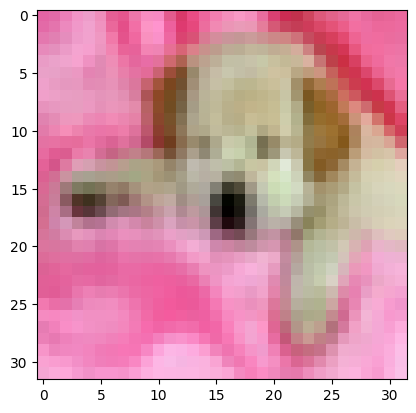

In [ ]:
# permute: [C, H, W] -> [H, W, C]
plt.imshow(x[0].permute(1, 2, 0)), y[0]

#### Build Model

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

IMG_SIZE = 32

Using device: cuda


nn.Sequential

In [ ]:
model = nn.Sequential(
    nn.Flatten(), # (C, H, W) -> (C*H*W)
    nn.Linear(in_features=IMG_SIZE*IMG_SIZE*3, out_features=64), # (C*H*W) -> (64)
    nn.ReLU(), # activation
    nn.Linear(64, 128), # (64) -> (128)
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, NUM_CLASS), # (128) -> NUM_CLASS
)

nn.Module Subclass

In [ ]:
# Define model
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # (C, H, W) -> (C*H*W)
        self.base_model = nn.Sequential(
            nn.Linear(in_features=IMG_SIZE*IMG_SIZE*3, out_features=64), # (C*H*W) -> (64)
            nn.ReLU(),
            nn.Linear(64, 128), # (64) -> (128)
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, NUM_CLASS), # (128) -> NUM_CLASS
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.base_model(x)
        return logits

In [ ]:
# init model and move to GPU device
model = NeuralNet().to(device)

In [ ]:
# Print basic model architecture
print(model)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (base_model): Sequential(
    (0): Linear(in_features=3072, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
# Use torchsummary to print advanced info
import torchsummary

torchsummary.summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 64]         196,672
              ReLU-3                   [-1, 64]               0
            Linear-4                  [-1, 128]           8,320
              ReLU-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 222,794
Trainable params: 222,794
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 0.85
Estimated Total Size (MB): 0.89
----------------------------------------------------------------


In [ ]:
# Use torchinfo to print advanced info
!pip install torchinfo

import torchinfo
torchinfo.summary(model, input_size=(BATCH_SIZE, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNet                                [256, 10]                 --
├─Flatten: 1-1                           [256, 3072]               --
├─Sequential: 1-2                        [256, 10]                 --
│    └─Linear: 2-1                       [256, 64]                 196,672
│    └─ReLU: 2-2                         [256, 64]                 --
│    └─Linear: 2-3                       [256, 128]                8,320
│    └─ReLU: 2-4                         [256, 128]                --
│    └─Linear: 2-5                       [256, 128]                16,512
│    └─ReLU: 2-6                         [256, 128]                --
│    └─Linear: 2-7                       [256, 10]                 1,290
Total params: 222,794
Trainable params: 222,794
Non-trainable params: 0
Total mult-adds (M): 57.04
Input size (MB): 3.15
Forward/backward pass size (MB): 0.68
Params size (MB): 0.89
Estimated Total Size (MB): 4

#### Training: Optimizing the Model Parameters

In [ ]:
loss_fn = nn.CrossEntropyLoss() # Softmax + negative log likelihood loss (nn.NLLLoss)
optimizer = torch.optim.SGD(
    params=model.parameters(), # parameters to optimize
    lr=1e-2, # learning rate: 1e-4, 1e-2...
)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to device

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [ ]:
EPOCHS = 10
logs = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_dataloader, model, loss_fn)

    print(f'EPOCH: {epoch} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 0     train_loss: 2.2990, train_acc: 0.129     val_loss: 2.2931, val_acc: 0.194 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 1     train_loss: 2.2851, train_acc: 0.183     val_loss: 2.2729, val_acc: 0.178 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 2     train_loss: 2.2504, train_acc: 0.175     val_loss: 2.2164, val_acc: 0.188 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 3     train_loss: 2.1671, train_acc: 0.190     val_loss: 2.1138, val_acc: 0.192 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 4     train_loss: 2.0835, train_acc: 0.210     val_loss: 2.0605, val_acc: 0.232 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 5     train_loss: 2.0386, train_acc: 0.251     val_loss: 2.0212, val_acc: 0.250 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 6     train_loss: 2.0038, train_acc: 0.266     val_loss: 1.9944, val_acc: 0.275 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 7     train_loss: 1.9701, train_acc: 0.281     val_loss: 1.9538, val_acc: 0.275 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 8     train_loss: 1.9394, train_acc: 0.292     val_loss: 1.9288, val_acc: 0.294 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 9     train_loss: 1.9146, train_acc: 0.306     val_loss: 1.9061, val_acc: 0.304 


#### Logs

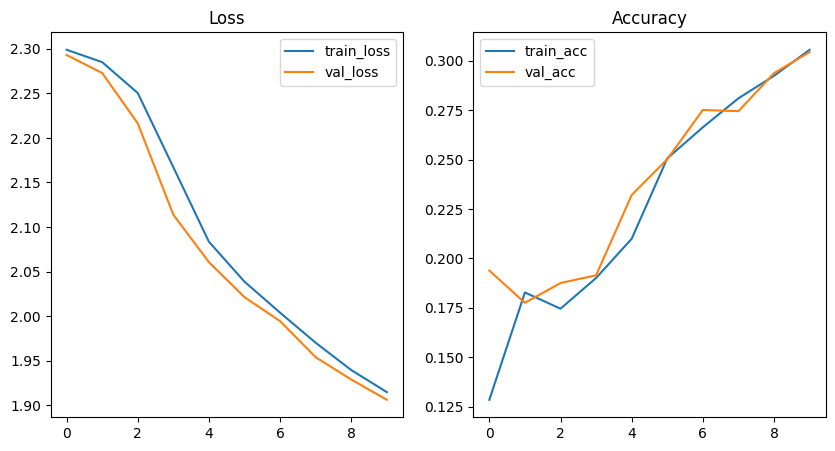

In [ ]:
# Plot loss curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(logs['train_loss'])
plt.plot(logs['val_loss'])
plt.legend(['train_loss', 'val_loss'])
# plot acc
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(logs['train_acc'])
plt.plot(logs['val_acc'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

#### Save Model

Saving & Loading Model (weights only)

**Recommended**

In [ ]:
# model parameters
model.state_dict()

OrderedDict([('base_model.0.weight',
              tensor([[ 0.0006,  0.0013,  0.0159,  ...,  0.0109,  0.0054, -0.0148],
                      [-0.0038, -0.0151,  0.0079,  ...,  0.0003,  0.0039,  0.0125],
                      [ 0.0014, -0.0142,  0.0049,  ..., -0.0041,  0.0134, -0.0105],
                      ...,
                      [ 0.0069, -0.0001,  0.0055,  ...,  0.0216, -0.0089,  0.0066],
                      [ 0.0066, -0.0100,  0.0127,  ...,  0.0169,  0.0174, -0.0050],
                      [ 0.0125,  0.0093, -0.0010,  ..., -0.0021,  0.0135, -0.0127]],
                     device='cuda:0')),
             ('base_model.0.bias',
              tensor([ 0.0193,  0.0106,  0.0160, -0.0017, -0.0030,  0.0072,  0.0581, -0.0039,
                       0.0198, -0.0087,  0.0013,  0.0216, -0.0192,  0.0217, -0.0050, -0.0170,
                      -0.0060, -0.0191,  0.0034,  0.0204, -0.0094,  0.0005, -0.0142,  0.0096,
                      -0.0027, -0.0013, -0.0158,  0.0027,  0.0017,  0.0150

In [ ]:
PATH = './model_weights.pth' # .pth or .pt
# save weights
torch.save(model.state_dict(), PATH)

# load weights
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Saving & Loading Model (entire model)

In [ ]:
MODEL_PATH = './model.pth'
# save model
torch.save(model, MODEL_PATH)
# load model
model = torch.load(MODEL_PATH)

#### Evaluation

In [ ]:
# load model
model = NeuralNet()

model.load_state_dict(torch.load(PATH))
model.eval()

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (base_model): Sequential(
    (0): Linear(in_features=3072, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)

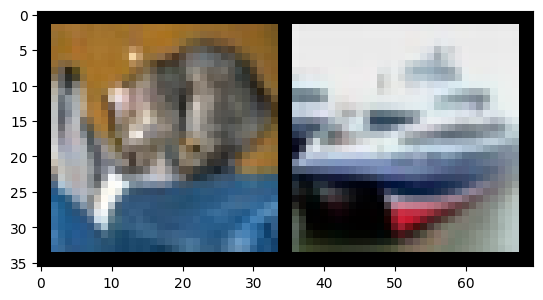

In [ ]:
# take first 2 images
n = 2
for (images, labels) in val_dataloader:
    images, labels = images[:n], labels[:n]
    images_grid = torchvision.utils.make_grid(images[:n])
    images_grid = images_grid.permute(1, 2, 0) # (C, H, W) -> (H, W, C)
    plt.imshow(images_grid.numpy())
    break

In [ ]:
# take first 2 images
n = 2
for (images, labels) in val_dataloader:
    images, labels = images[:n], labels[:n]
    break

# Predict by model
with torch.no_grad():
    pred = model(images) # predict logits
print('raw_prediction logtis', pred, pred.shape, sep="\n")

raw_prediction logtis
tensor([[-0.2415, -0.6147,  0.3675,  0.5100,  0.1900,  0.8240, -0.0602, -0.0368,
         -0.5369, -1.3382],
        [ 0.8300,  2.3952, -1.1274, -1.0243, -2.0254, -1.8009, -1.9789, -0.8321,
          2.4868,  2.6965]])
torch.Size([2, 10])


In [ ]:
# 經過softmax()函式轉換成機率的樣子
pred_softmax = nn.Softmax(dim=1)(pred) # probabilities
print('prediction after softmax', pred_softmax, pred_softmax.shape, sep="\n")

prediction after softmax
tensor([[0.0736, 0.0507, 0.1353, 0.1560, 0.1133, 0.2135, 0.0882, 0.0903, 0.0548,
         0.0246],
        [0.0550, 0.2633, 0.0078, 0.0086, 0.0032, 0.0040, 0.0033, 0.0104, 0.2885,
         0.3558]])
torch.Size([2, 10])


In [ ]:
# max_prob: max probability of each samples
# predicted_cls: the index of max prob
max_prob, predicted_cls = torch.max(pred_softmax, dim=1)

In [ ]:
predicted_cls = pred_softmax.argmax(dim=1)

In [ ]:
predicted_cls

tensor([5, 9])

In [ ]:
pred_softmax.argmax(dim=1)

tensor([5, 9])

In [ ]:
print('GroundTruth: ', ' '.join(class_names[labels[j]] for j in range(n)))
print('Prediction: ', ' '.join(class_names[predicted_cls[j]] for j in range(n)))

GroundTruth:  cat ship
Prediction:  dog truck
